In [ ]:
"""
Model Training Script for NSW Real Estate Price Prediction

This script trains an XGBoost regression model to predict log-transformed sale prices
using feature-engineered real estate data.

Main steps:
- Load processed dataset with encoded features.
- Select numeric and boolean features as input (X) and log sale price as target (y).
- Split dataset into train and test sets.
- Define XGBoost regressor and a hyperparameter grid.
- Perform GridSearchCV to find best hyperparameters using 3-fold CV.
- Save the best tuned model for later inference.
- Evaluate performance on test set (RMSE, MAE, R²).
- Visualize feature importance for interpretability.

Author: Ambarish Shashank Gadgil
Date:04/07/2024"""


import pandas as pd
from sklearn.model_selection import train_test_split


df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_1/real_estate_price_prediction/data/processed/feature_engineered_data.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121917 entries, 0 to 121916
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Street_Name          121917 non-null  object 
 1   Suburb               121917 non-null  object 
 2   Postcode             121917 non-null  float64
 3   Sale_Price           121917 non-null  float64
 4   Description          121917 non-null  object 
 5   Address              121917 non-null  object 
 6   Sale_Year            121917 non-null  int64  
 7   Sale_Month           121917 non-null  int64  
 8   Sale_Weekday         121917 non-null  int64  
 9   Log_Sale_Price       121917 non-null  float64
 10  Property_Use_R       121917 non-null  bool   
 11  Property_Use_V       121917 non-null  bool   
 12  Season_Spring        121917 non-null  bool   
 13  Season_Summer        121917 non-null  bool   
 14  Season_Winter        121917 non-null  bool   
 15  Suburb_encoded   

In [14]:
#Extracting numeric columns for model training

X = df.select_dtypes(include=["int64", "float64", "bool"])
X=X.drop(columns=['Log_Sale_Price','Sale_Price'])
y = df['Log_Sale_Price']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)


X_train: (97533, 13)
X_test:  (24384, 13)
y_train: (97533,)
y_test:  (24384,)


In [15]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV

#Definig model and hyperparameter grid

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [16]:
#Grid search with cross validation

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [17]:
#Saving the trained model

import joblib

joblib.dump(grid_search.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/Project_1/real_estate_price_prediction/models/tuned_xgb_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/Project_1/real_estate_price_prediction/models/tuned_xgb_model.pkl']

In [18]:
tuned_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict on test set
y_pred = tuned_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
RMSE: 0.45
MAE:  0.27
R²:   0.5979


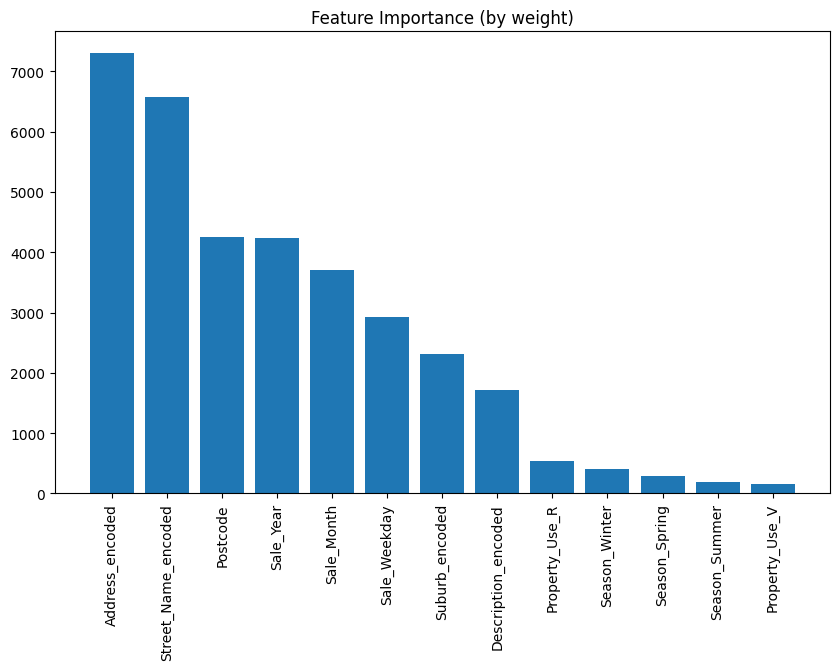

In [19]:
import matplotlib.pyplot as plt
#Feature Importance

# Get feature importance scores from the best model
importance = tuned_model.get_booster().get_score(importance_type='weight')

# Sort by importance
importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(10,6))
plt.bar(importance.keys(), importance.values())
plt.xticks(rotation=90)
plt.title("Feature Importance (by weight)")
plt.show()